# Comparaison des Modeles

## Importer les packages

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
import time
import datetime as dt
today = dt.datetime.now().date().strftime('%Y%m%d')

from warnings import simplefilter
simplefilter('ignore')

In [2]:
# models necessary to define the forecasting models 
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS, 
    StatsForecastAutoTheta
)
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.fbprophet import Prophet

## Lire les donnees

In [3]:
data_folder = '../data'
filename = os.path.join(data_folder, 'script_001_bdd.csv')
data = pd.read_csv(filename, parse_dates=['date'], index_col=['date']).dropna().sort_index()

In [4]:
data.head(2)

,BMC,jo_RIM,Pre_ramadan,Ramadan,Pre_Afitr,Post_AFitr,Pre_Akebir,Post_Akebir,Pre_ferie,Post_ferie,Pre_elec,Post_elec,Achat_or,Last_Day,First_Day
date,,,,,,,,,,,,,,,
2018-04-02,17.355653,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0
2018-04-03,17.442521,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0


In [5]:
exog_l = list(set(data.columns) - set(['BMC']))

## Section1: Difinir la liste des modeles a comparer

### Method 1: Liste des modeles a partir d'une list d'objets LiquidityForecast
Choix par defaut si vous avez deja estimer des modeles et vous voulez les comparer sans les reestimer

import pickle
with open('forecasters/BCM_ARIMA_forecaster.pkl', 'rb') as file:
    LF_ARIMA = pickle.load(file)
    
with open('forecasters/BCM_ETS_forecaster.pkl', 'rb') as file:
    LF_ETS = pickle.load(file)
    
LFMS = lfs.LiquidityForecastModelSelect(LF_list= [LF_ARIMA, LF_ETS])

### Method 2: Liste des modeles a partir d'un dictionnaire
Choix par defaut si vous voulez reestimer les modeles

In [6]:
ForecastingModels = {
    "Naive_1": NaiveForecaster(sp=5),
    "Naive_2": NaiveForecaster(sp=252),
    "Naive_3": NaiveForecaster(sp=65),
    "Naive_4": NaiveForecaster(sp=20),
}

In [7]:
import forecast.model_select as lfs
LFMS = lfs.ForecastModelSelect(
            data= data,
            depvar_str = 'BMC',                 
            exog_l=None,
            fh = 4,
            pct_initial_window=0.5,
            step_length = 25,
            models_d = ForecastingModels,
            freq = 'B',
            mode = 'nbest_average_horizon',
            score = 'RMSE', 
            nbest = 2
)

## Section 2: Ajuster les modeles

In [8]:
LFMS.fit()

## Section 3: Evaluation Hors Echantillon

In [9]:
summary_horizon, summary_results = LFMS.evaluate()


Start forecaster Naive_1 evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.021 minutes

Start forecaster Naive_2 evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.153 minutes

Start forecaster Naive_3 evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.053 minutes

Start forecaster Naive_4 evalution....
 Depending on the forecaster this step may take couple of minutes. Please don't kill the kernel
Evaluation time: 0.028 minutes


In [10]:
summary_horizon

Naive_1             Naive_2             Naive_3             Naive_4  \
             RMSE      MAPE      RMSE      MAPE      RMSE      MAPE      RMSE   
horizon                                                                         
1        0.271510  0.007519  4.240348  0.136641  1.246351  0.038389  0.788121   
2        0.289118  0.008113  4.270111  0.136711  1.270926  0.039167  0.762425   
3        0.290705  0.007917  4.307163  0.137530  1.237404  0.038317  0.756828   
4        0.337214  0.008554  4.309374  0.137042  1.196645  0.036244  0.753681   

                   
             MAPE  
horizon            
1        0.021491  
2        0.020288  
3        0.021068  
4        0.021433

In [11]:
summary_results

,Naive_1,Naive_2,Naive_3,Naive_4
Number of Folds,25,25,25,25
Avg Fit time (s),0.002096,0.002181,0.002153,0.002134
Avg_pred_time (s),0.03606,0.352965,0.112885,0.053095
Smallest training window,620,620,620,620
Largest training window,1220,1220,1220,1220
First cutoff,2020-08-14 00:00:00,2020-08-14 00:00:00,2020-08-14 00:00:00,2020-08-14 00:00:00
Last cutoff,2022-12-02 00:00:00,2022-12-02 00:00:00,2022-12-02 00:00:00,2022-12-02 00:00:00
Avg MAPE,0.008026,0.136981,0.038029,0.02107
Avg RMSE,0.247933,3.908062,1.092278,0.626778


### Section 4: Select the best model

In [12]:
LFMS.select_best(score = 'MAPE')

horizon,1,2,3,4
Best_1,Naive_1,Naive_1,Naive_1,Naive_1
Best_2,Naive_4,Naive_4,Naive_4,Naive_4
Best_3,Naive_3,Naive_3,Naive_3,Naive_3
Best_4,Naive_2,Naive_2,Naive_2,Naive_2


In [13]:
LFMS.avg_oos_horizon['MAPE']

,Naive_1,Naive_2,Naive_3,Naive_4,Model Avg (all models),Best 2 Model (over all),Best 2 Model (per horizon)
horizon,,,,,,,
1,0.007519,0.136641,0.038389,0.021491,0.051010,0.014505,0.014505
2,0.008113,0.136711,0.039167,0.020288,0.051070,0.014200,0.014200
3,0.007917,0.137530,0.038317,0.021068,0.051208,0.014492,0.014492
4,0.008554,0.137042,0.036244,0.021433,0.050818,0.014994,0.014994


<Axes: title={'center': 'Performance des Modeles Hors Echantillon'}, ylabel='Racine des moindres quarre'>

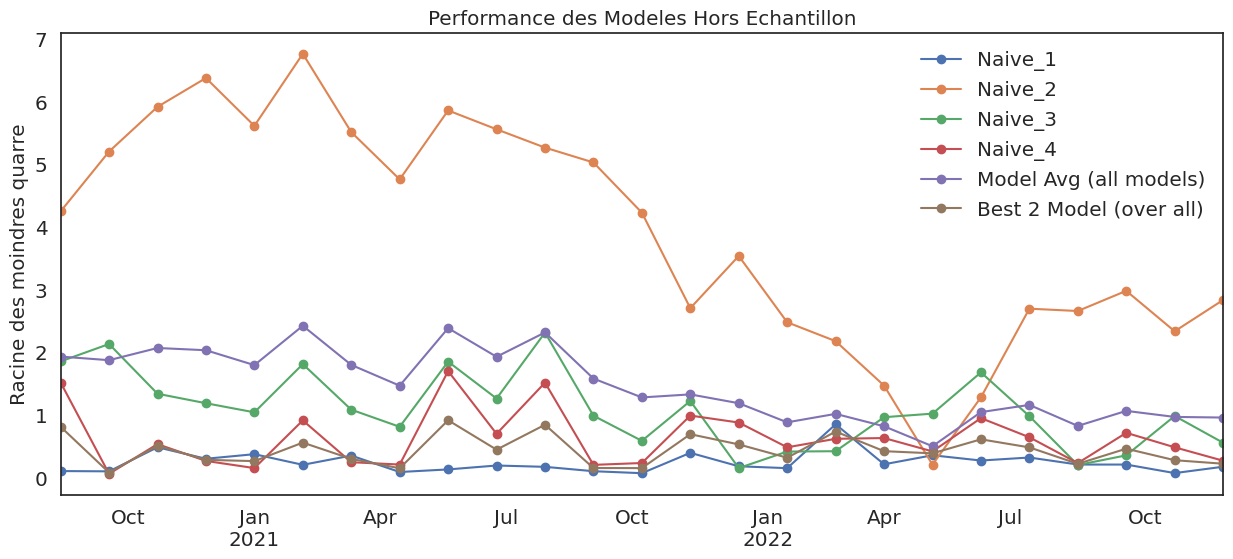

In [14]:
LFMS.plot_model_compare(
    score ='RMSE',
    view = 'cutoff',
    xlabel = '',
    ylabel = 'Racine des moindres quarre',
    title = 'Performance des Modeles Hors Echantillon')

<Axes: title={'center': 'Performance des Modeles Hors Echantillon'}, xlabel='Horizon', ylabel='Racine des moindres quarre'>

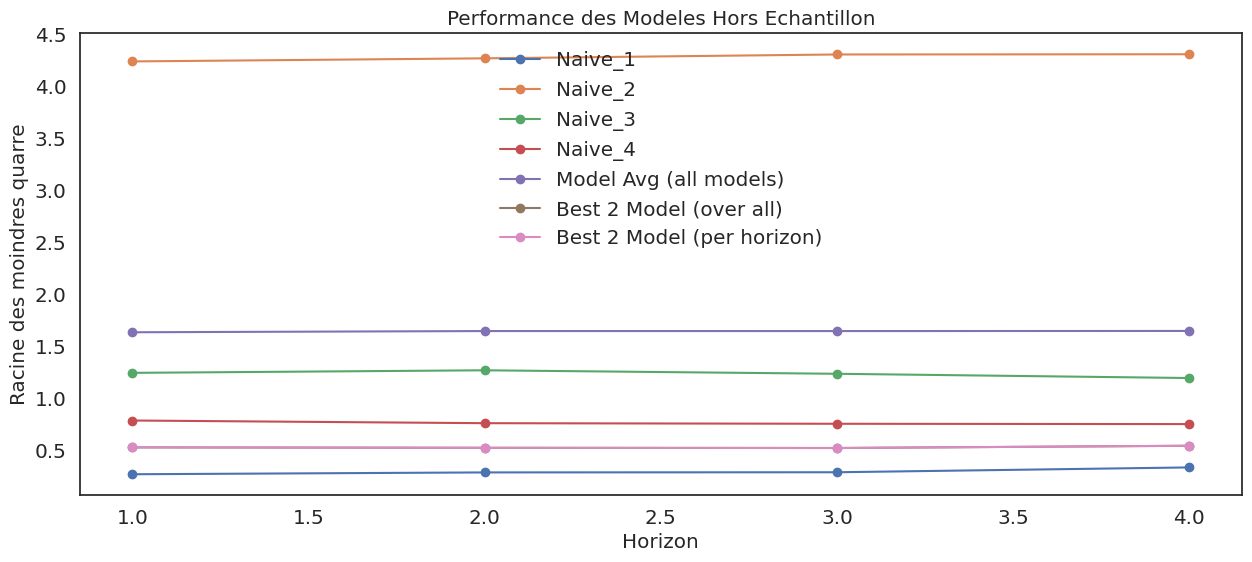

In [15]:
LFMS.plot_model_compare(
    score ='RMSE',
    view = 'horizon',
    xlabel = 'Horizon',
    ylabel = 'Racine des moindres quarre',
    title = 'Performance des Modeles Hors Echantillon')

## Section 5: Generer les prediction

In [16]:
LFMS.predict?

Signature:
LFMS.predict(
    X: Optional[pandas.core.frame.DataFrame] = None,
    fh: Optional[sktime.forecasting.base._fh.ForecastingHorizon] = None,
    coverage: float = 0.9,
    mode: Optional[str] = None,
    score: Optional[str] = None,
    nbest: Optional[int] = None,
    ret_underlying: bool = False,
) -> Tuple[pandas.core.series.Series, pandas.core.frame.DataFrame]
Docstring:
Make forecasts using the specified aggregation mode.

Parameters
----------
    X : pd.DataFrame, optional
        The exogenous variables used for prediction. Default is None and it takes the value entered at initialization..
    fh : ForecastingHorizon, optional
        The forecasting horizon. Default is None and it takes the value entered at initialization..
    coverage : float, optional
        The prediction interval coverage. Default is 0.9.
    mode : str, optional
        The aggregation mode for predictions. Default is None and it takes the value entered at initialization.. 
        Available v

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Prediction des Billets et Monnaie en Circulation'}, ylabel='BMC - Millions de MRU'>)

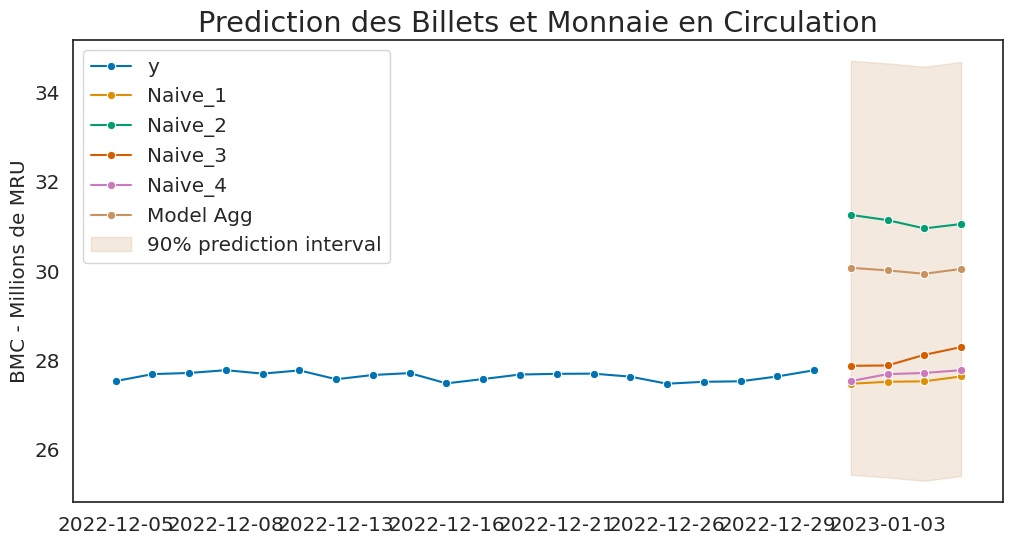

In [17]:
y_pred, y_pred_ints, preds, pred_ints = LFMS.predict(mode='inverse_score', ret_underlying=True)
LFMS.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints, 
                     ylabel ='BMC - Millions de MRU',
                     title = 'Prediction des Billets et Monnaie en Circulation',
                     figsize=(12,6)
                    )  

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Prediction des Billets et Monnaie en Circulation'}, ylabel='BMC - Millions de MRU'>)

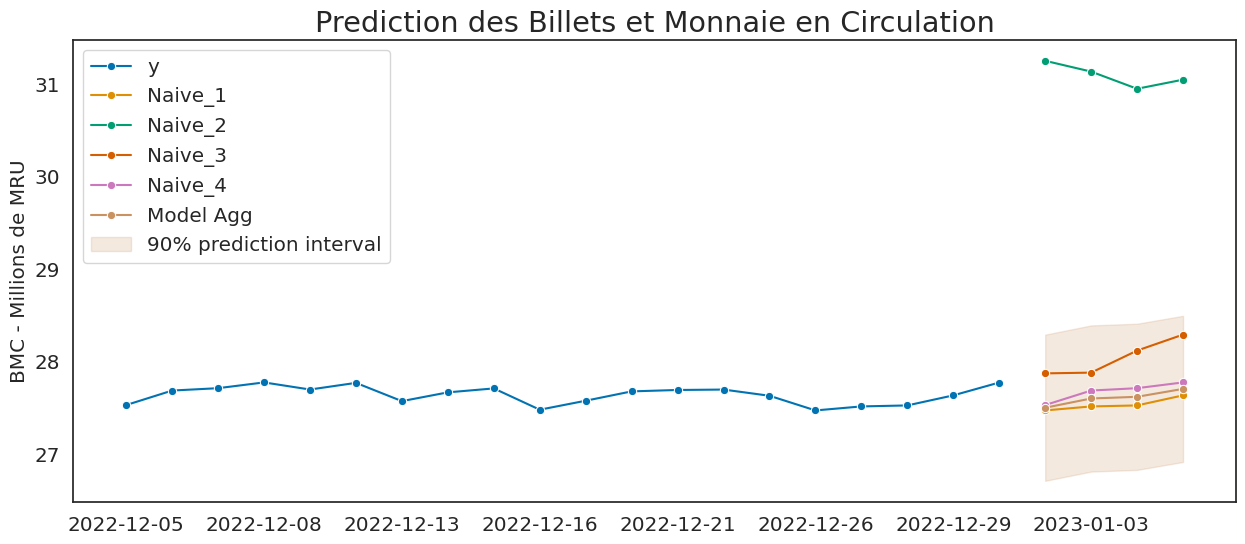

In [18]:
y_pred, y_pred_ints, preds, pred_ints = LFMS.predict(mode='nbest_average_horizon', ret_underlying=True)
LFMS.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints, 
                     ylabel ='BMC - Millions de MRU',
                     title = 'Prediction des Billets et Monnaie en Circulation'
                    )    

## Section 6: Mettre a jour les donnees et Generer les prediction

In [19]:
# create a dataframe with the new data
newdata = pd.concat([data, 
                     pd.DataFrame(index=[y_pred.index[0]], columns =data.columns)
                    ])
newdata.loc[y_pred.index[0], 'BMC'] = y_pred.iloc[0]
newdata = newdata.ffill()

In [20]:
y_pred, y_pred_ints, preds, pred_ints = LFMS.update(newdata=newdata, mode='inverse_score', ret_underlying=True)

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'Prediction des Billets et Monnaie en Circulation'}, ylabel='BMC - Millions de MRU'>)

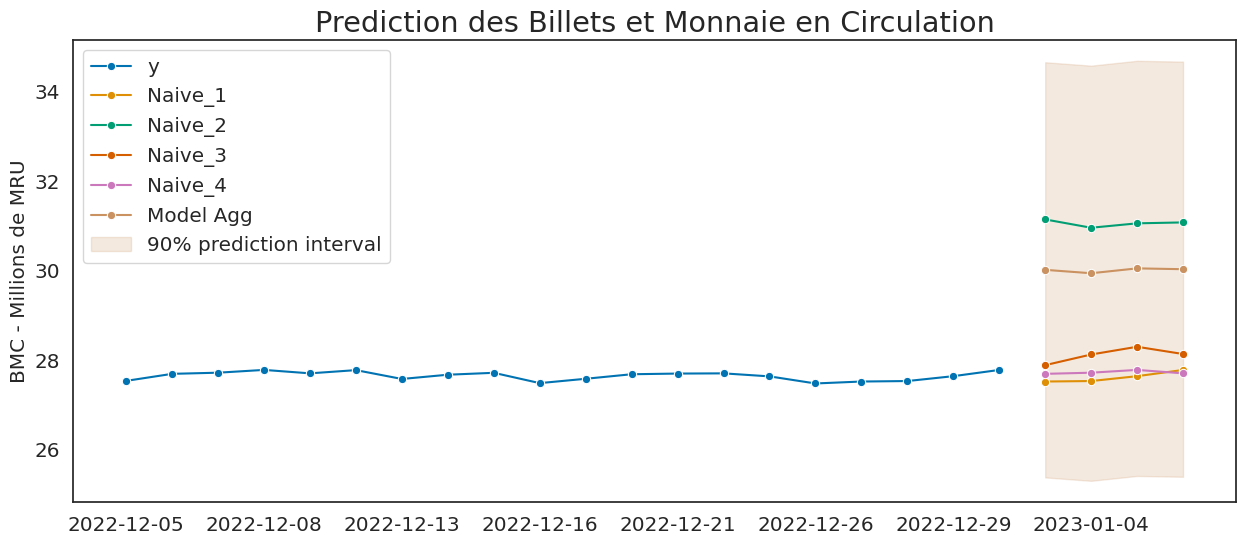

In [21]:
LFMS.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints, 
                     ylabel ='BMC - Millions de MRU',
                     title = 'Prediction des Billets et Monnaie en Circulation'
                    )    